DQN Agent
====
Code taken from PyTorch DQN tutorial, then modified to work on our environment.

In [1]:
import gym
import gym_drone
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

Intialize environment along with the matplotlib figure.
- DroneCardinal-v0 is the name of the environment to initialize
- Rows and columns determine the shape of the environment area
- Memory capacity says how many of the last steps shall be remembered and displayed when rendering with 'notebook' mode.
- Ax takes a matplotlib plot, which it will plot to if given, otherwise plot to the default pyplot. This makes it so we can have the rendering of the playing as a matplotlib subplot.

array([25, 15, 76, 68])

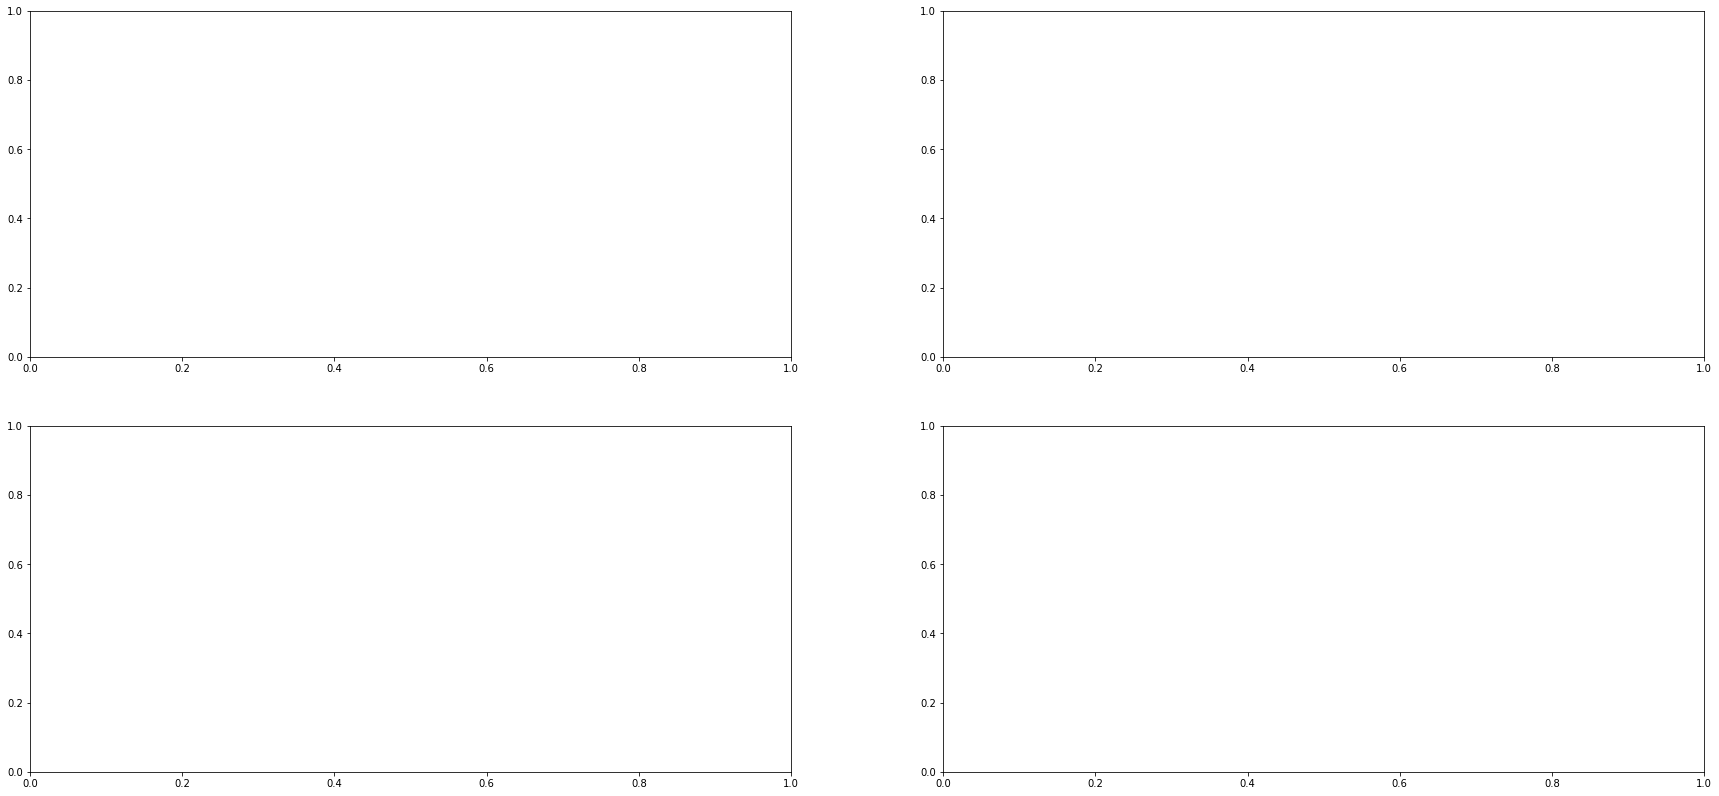

In [2]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(30)
fig.set_figheight(14)

grid_shape = (105, 105)
env = gym.make('DroneCardinal-v0',
               rows=grid_shape[0],
               columns=grid_shape[1],
               memory_capacity=50,
               ax=ax[1][0]).unwrapped
env.reset()

In [3]:
print(env._get_obs())

[25 15 76 68]


In [4]:
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import laps, redis, loader
from Dijkstra.Dijkstra import *

grid = env._grid

grid = []
width, height = grid_shape
for x in range(width):
    grid.append([])
    for y in range(height):
        grid[x].append(Node(env._grid[x, y], (x, y)))

#for y in grid:
#    string = ''
#    for x in y:
#        string += str(x.point)
#    print(string)

edges = get_edges(grid)

#print(len(get_neighbours(grid[1][1], grid)))

ModuleNotFoundError: No module named 'laps'

Set up the ReplayMemory object type. 

It is how transitions in the environment is stored, and randomly given back with the sample function, to train the neural network.

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Network
=======
The network is a convolutional neural network, which uses ReLu activation function.

In [6]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        #self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        #self.bn1 = nn.BatchNorm2d(16)
        #self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        #self.bn2 = nn.BatchNorm2d(32)
        #self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        #self.bn3 = nn.BatchNorm2d(32)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        #def conv2d_size_out(size, kernel_size = 5, stride = 2):
        #    return (size - (kernel_size - 1) - 1) // stride  + 1
        #convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        #convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        #linear_input_size = convw * convh * 32
        #self.head = nn.Linear(linear_input_size, outputs)
        self.head = nn.Linear(24 * 24 * 32, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

Resize the image to fit neural network, change order of channels to fit the expected PyTorch input type, and send image to device.

In [7]:
resize = T.Compose([T.ToPILImage(),
                    #T.Resize(40, interpolation=Image.CUBIC),
                    #T.Resize(40),
                    T.Resize(211),
                    T.ToTensor()])

pos_blur_size = 10
# goal_blur_size = (diagonal = env._grid.shape[0] + env._grid.shape[1] - 1) # blur size diagonal of board
goal_blur_size = 10
white_channel = np.zeros(grid_shape)
def get_screen():
    screen = env.render(mode='rgb_array')
    # blur grid
    screen = blur_grid(screen)
    # recenter around drone
    #screen = recenter_grid_on_position(screen)
    # set the red channel (height) to zero
    screen[:, :, 0] = white_channel
    
    screen = screen.transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = screen.type(torch.FloatTensor)
    return resize(screen).unsqueeze(0).to(device)

def lattice_distance(a, b):
    a_x, a_y = a
    b_x, b_y = b
    return abs(a_x - b_x) + abs(a_y - b_y)

def blur_grid(rgb_array):
    #green_channel = rgb_array[:,:,1]
    #blue_channel = rgb_array[:,:,2]
    goal = tuple(env._get_obs()[2:])
    drone_pos = tuple(env._get_obs()[:2])
    diagonal = env._grid.shape[0] + env._grid.shape[1] - 1
    
    #for x, column in enumerate(green_channel):
    for x, column in enumerate(rgb_array[:,:,1]):
        for y, cell in enumerate(column):
            # drone position blurring, using distance from drone
            distance = lattice_distance((x, y), drone_pos)
            if (distance <= pos_blur_size):
                rgb_array[x][y][1] = (255 / pos_blur_size) * max(pos_blur_size - distance, 0)
            #green_channel[x][y] = (255 / pos_blur_size) * max(pos_blur_size - distance, 0)
            # goal blurring, using distance from goal
            distance = lattice_distance((x, y), goal)
            if (distance <= goal_blur_size):
                rgb_array[x][y][2] = (255 / goal_blur_size) * max(goal_blur_size - distance, 0)
            #blue_channel[x][y] = (255 / goal_blur_size) * max(goal_blur_size - distance, 0)
            
    #rgb_array[:, :, 1] = green_channel
    #rgb_array[:, :, 2] = blue_channel
    return rgb_array

def recenter_grid_on_position(rgb_array):
    rows, columns = grid_shape
    drone_pos = env._drone_pos
    drone_x, drone_y = drone_pos
    offset_x = (columns - 1) - drone_x
    offset_y = (rows - 1) - drone_y
    
    #print(drone_x)
    #print(offset_x)
    #return rgb_array
    
    new_grid = np.zeros((rows * 2 - 1, columns * 2 - 1, 3)) + 255
    for x, column in enumerate(rgb_array):
        for y, row in enumerate(column):
            for channel, cell in enumerate(row):
                #new_grid[x + offset_x, y + offset_y, channel] = #rgb_array[x, y, channel]
                new_grid[x + offset_x, y + offset_y, channel] = cell
    return new_grid

#print(recenter_grid_on_position(env.render(mode='rgb_array')))
#grid_shape = (8, 8)
#env = gym.make('DroneCardinal-v0',
#               rows=grid_shape[0],
#               columns=grid_shape[1],
#               memory_capacity=50,
#               ax=ax[2]).unwrapped
#env.reset()
#test = env.render(mode='rgb_array')
#blur_grid(test)[:, :, 1]
#print(recenter_grid_on_position(env.render(mode='rgb_array'))[:,:,0])

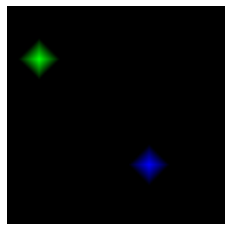

In [8]:
plt.imshow(np.swapaxes(np.swapaxes(np.squeeze(np.asarray(get_screen()), 0), 0, 2), 0, 1))
plt.axis('off')
plt.show()

In [9]:
env.step(1)

(array([25, 16, 76, 68]), -41.0, False, {})

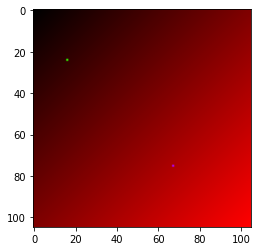

In [10]:
env.step(1)
plt.imshow(env.render(mode='rgb_array'))
plt.show()

In [11]:
BATCH_SIZE = 128
GAMMA = 0.999
#GAMMA = 0.1
EPS_START = 0.9
EPS_END = 0.2
#EPS_END = 0.0
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = env.render(mode='rgb_array')
screen_height, screen_width, _ = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

# Reset these whenever 
episode_durations = []
episode_rewards = []
episode_best_reward = []

In [12]:
steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            state = get_screen()
            policy_net.eval()
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [13]:
episode_durations = []
episode_rewards = []
episode_best_reward = []
def plot_durations():
    # Plot episode durations
    ax[0][0].cla()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    ax[0][0].set_xlabel('Episode')
    ax[0][0].set_ylabel('Duration')
    ax[0][0].plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[0][0].plot(means.numpy())
        
    # Plot episode rewards
    ax[0][1].cla()
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    best_rewards_t = torch.tensor(episode_best_reward, dtype=torch.float)
    ax[0][1].set_xlabel('Episode')
    ax[0][1].set_ylabel('Reward')
    ax[0][1].plot(rewards_t.numpy())
    ax[0][1].plot(best_rewards_t.numpy())
    
    # Plot environment
    env.render()

    # Plot environment as seen by the agent
    ax[1][1].imshow(np.swapaxes(np.swapaxes(np.squeeze(np.asarray(get_screen()), 0), 0, 2), 0, 1))
    ax[1][1].axis('off')
    
    # pause a bit so that plots are updated
    plt.pause(0.001)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(fig)


In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values,
                            expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Reward Function:
===
Reward 1 for correct direction, -2 otherwise.

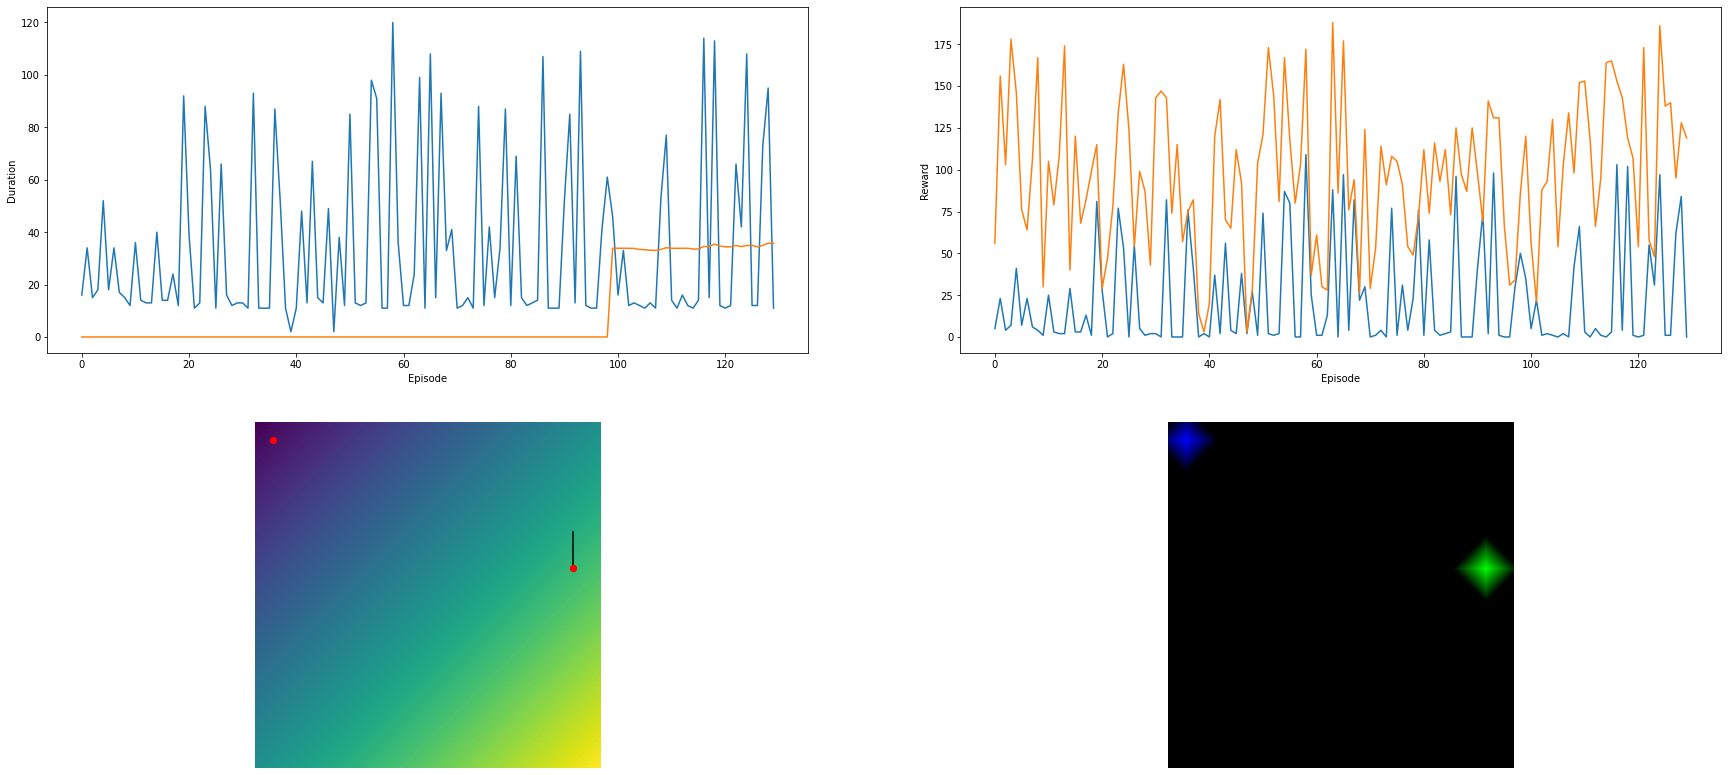

KeyboardInterrupt: 

In [15]:
num_episodes = 2000
episode_durations = []
episode_rewards = []
episode_best_reward = []

possible_start_points = [(5,5), (100, 5), (5, 100), (100, 100)]
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    
    #env._goal_pos = (5, 5)
    env._goal_pos = random.choice(possible_start_points)
    mistakes = 0
    
    current_screen = get_screen()
    state = current_screen
    total_reward = 0
    highest_grid_value = np.amax(env._grid)
    for t in count():
        last_x, last_y, _, _ = env._get_obs()
        
        # Select and perform an action
        action = select_action(state)
        state_tuple, reward, done, _ = env.step(action.item())
        drone_x, drone_y, goal_x, goal_y = state_tuple
        drone_point = (drone_x, drone_y)
        goal_point = (goal_x, goal_y)
        
        # Hijack reward calculation (temporary?)
        if (drone_x, drone_y) == (goal_x, goal_y):
            reward = np.float64(0)
        else:
            diff = abs(goal_x - drone_x) + abs(goal_y - drone_y)
            last_diff = abs(goal_x - last_x) + abs(goal_y - last_y)
            if (last_diff > diff):
                reward = np.float64(1)
            else:
                reward = np.float64(0)
            
        
        total_reward += reward
        reward = torch.tensor([reward], device=device).type(torch.float)
        if t == 0:
            episode_best_reward.append(abs(last_x - goal_x) + abs(last_y - goal_y))
        if t > 200 or lattice_distance(drone_point, goal_point) < 2:
            done = True
        if reward == 0:
            mistakes += 1
        
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done or mistakes > 10:
            #print(t + 1)
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)
            plot_durations()
            break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

In [ ]:
edges = get_edges(grid)
get_cost(dijkstra(edges, (2,5), (0,0)))
#path = get_path(dijkstra_path)

In [ ]:
get_cost(dijkstra(edges, (2,0), (0,0)))

In [ ]:
test = env.render(mode='rgb_array')
print(env._get_obs())

def blur_grid(rgb_array):
    def lattice_distance(a, b):
        a_x, a_y = a
        b_x, b_y = b
        return abs(a_x - b_x) + abs(a_y - b_y)
    
    red_channel = rgb_array[:,:,2]
    goal = tuple(env._get_obs()[2:])
    diagonal = env._grid.shape[0] + env._grid.shape[1] - 1
    
    for x, column in enumerate(red_channel):
        for y, cell in enumerate(column):
            distance = lattice_distance((x, y), goal)
            red_channel[x][y] = (255 / diagonal) * (distance + 1)
    rgb_array[:, :, 2] = red_channel
    return rgb_array

test = blur_grid(test)
print(test[:, :, 2])